# Character RNN Sequence Generation Tutorial

This follows the tutorial here: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [1]:
%matplotlib inline
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('dark_background')

### Import functions used in last tutorial

In [198]:
files = glob.glob("/home/clarencenhuang/data/pytorch-tutorials/names/*.txt")
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters) + 1
letter_to_idx = {c:i for i,c in enumerate(all_letters)}
idx_to_letter = {i:c for i,c in enumerate(all_letters)}
# we use None to denote EOS
letter_to_idx[None] = n_letters -1
idx_to_letter[n_letters -1] = None
n_hidden = 128

# remove wierd characters
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)

# parse text into lines and remove wierd characters
def read_lines(fname):
    with open(fname, encoding='utf8') as fh:
        lines = fh.read().strip().split('\n')
        return list(map(unicode_to_ascii, lines))

# parse and create mapping of category names to index
category_lines = {}
for fname in files:
    category = os.path.splitext(os.path.basename(fname))[0]
    category_lines[category] = read_lines(fname)
n_categories = len(category_lines.keys())
all_categories = sorted(category_lines.keys())
cat2idx = {c:i for i,c in enumerate(sorted(category_lines.keys()))}
idx2cat = {i:c for i,c in enumerate(sorted(category_lines.keys()))}


def letter2tensor(l):
    t = torch.zeros(1, n_letters)
    t[0, letter_to_idx[l]] = 1
    return t

# character embedding 1-hot
def line2tensor(line):
    t = torch.zeros(len(line), 1, n_letters)
    for i in range(len(line)):
        l = line[i]
        t[i,:] = letter2tensor(l)
    return t

def category_from_output(o):
    idx = o.topk(1)[1].item()
    return idx2cat[idx], idx

# get training example
def random_training_sample():
    category = np.random.choice(all_categories)
    line = np.random.choice(category_lines[category])
    line_tensor = line2tensor(line)
    return category, line, cat2tensor(category), line_tensor


def cat2tensor(cat):
    category_tensor = torch.zeros((1, n_categories))
    one_hot = cat2idx[cat]
    category_tensor[0, one_hot] = 1
    return category_tensor

def line2target(line):
    t = torch.zeros((len(line), 1), dtype=torch.long)
    for i in range(1, len(line)):
        t[i-1, 0] = letter_to_idx[line[i]]
    t[len(line)-1, 0] = letter_to_idx[None]
    return t


def out2letter(log_softmax_output, sample_randomly=False):
    if sample_randomly:
        probs = torch.exp(log_softmax_output.squeeze()).numpy()
        idx = np.random.choice(range(probs.shape[0]), p=probs)
    else:
        idx = log_softmax_output.squeeze().topk(1)[1].item() 
    return idx_to_letter[idx]

In [199]:
random_training_sample()[3].shape, n_letters

(torch.Size([7, 1, 58]), 58)

### Linear RNN

In [169]:
class LinearCell(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(LinearCell, self).__init__()
        input_dims = n_input + n_hidden + n_categories
        self.i2h = nn.Linear(input_dims, n_hidden)
        self.i2o = nn.Linear(input_dims, n_output)
        self.o2o = nn.Linear(n_output + n_hidden, n_output)
        
    def forward(self, x, cat, h):
        x = torch.cat((x, h, cat), 1)
        h = self.i2h(x)
        o = self.i2o(x)
        o = torch.cat((o, h), 1)
        o = self.o2o(o)
        o = F.dropout(o, 0.1)
        o = F.log_softmax(o, dim=1)
        return o, h
    
    def init_hidden(self):
        zeros = torch.zeros(1, n_hidden)
        if next(self.parameters()).is_cuda:
            zeros = zeros.cuda()
        return zeros

In [170]:
def train(cell, optimizer, criterion, epochs, print_every=5000, cuda=False):
    cell.train()
    tloss = 0
    losses = []
    for e in range(0, epochs):
        _, line, cat_tensor, line_tensor = random_training_sample()
        line_target = line2target(line)
        if cuda:
            cat_tensor, line_tensor, line_target = cat_tensor.cuda(), line_tensor.cuda(), line_target.cuda()
        
        optimizer.zero_grad()
        loss = 0
        tsteps = line_tensor.shape[0]
        h = cell.init_hidden()
        for t in range(tsteps):
            o, h = cell(line_tensor[t], cat_tensor, h)
            loss += criterion(o, line_target[t])
        loss.backward()
        optimizer.step()
        
        tloss += loss.item() / len(line)
        if e > 0 and e % print_every == 0:
            print(f"epoch: {e} loss: {tloss/print_every}")
            losses.append(tloss/print_every)
            tloss = 0
    return losses

In [171]:
cell = LinearCell(n_letters, n_hidden, n_letters)
criterion = nn.NLLLoss()
optimizer = optim.Adam(cell.parameters(), lr=0.001)
epochs = 100000

In [172]:
loss_linear = train(cell, optimizer, criterion, epochs, 5000, False)

epoch: 5000 loss: 2.3227754193390027
epoch: 10000 loss: 2.126191231218805
epoch: 15000 loss: 2.087683105596935
epoch: 20000 loss: 2.0712797393825766
epoch: 25000 loss: 2.0555229586725328
epoch: 30000 loss: 2.045932714700742
epoch: 35000 loss: 2.033117783477073
epoch: 40000 loss: 2.0308800922286006
epoch: 45000 loss: 2.0330728481131404
epoch: 50000 loss: 2.0243034010176455
epoch: 55000 loss: 2.018532508848233
epoch: 60000 loss: 2.0125394438467668
epoch: 65000 loss: 2.001213475367243
epoch: 70000 loss: 2.0037872709137003
epoch: 75000 loss: 2.0052951870913382
epoch: 80000 loss: 2.008198986106958
epoch: 85000 loss: 1.994281240485682
epoch: 90000 loss: 2.0033826825920675
epoch: 95000 loss: 1.9834694906933925


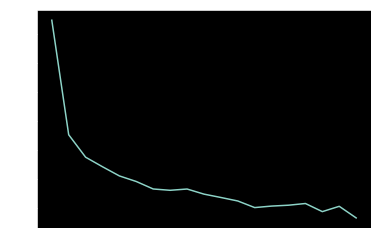

In [173]:
plt.plot(loss_linear)

In [250]:
def sampling(cell, cat, first_letter, sample_randomly=False):
    cell.cpu()
    word = first_letter
    letter = first_letter
    cat_tensor = cat2tensor(cat)
    cell.eval()
    h = cell.init_hidden()
    max_len = 20
    with torch.no_grad():
        for i in range(max_len):
            lt = letter2tensor(letter)
            o, h = cell(lt, cat_tensor, h)
            letter = out2letter(o, sample_randomly)
            if letter is None:
                return word
            else:
                word += letter
        return word
        

In [201]:
a = torch.tensor([[1,2,4]])
a.topk(1)[1].item()

2

In [242]:
sampling(cell, "Vietnamese", 'N', True)

'Neo'

In [115]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

### Re implement using a GRU (best cell from last class)

In [246]:
class WordGRU(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(WordGRU, self).__init__()
        self.gru = nn.GRUCell(n_input + n_categories, n_hidden)
        self.h2o = nn.Linear(n_hidden, n_output)
        
    def forward(self, x, cat, h):
        x = torch.cat((x, cat), 1)
        h = self.gru(x, h)
        o = self.h2o(h)
        o = F.dropout(o, 0.1)
        o = F.log_softmax(o, dim=1)
        return o, h
    
    def init_hidden(self):
        zeros = torch.zeros(1, n_hidden)
        if next(self.parameters()).is_cuda: zeros = zeros.cuda()
        return zeros
        

In [247]:
cell = WordGRU(n_letters, n_hidden, n_letters)
cell.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(cell.parameters(), lr=0.001)
epochs = 100000
loss_gru = train(cell, optimizer, criterion, epochs, 5000, True)

epoch: 5000 loss: 2.304542747737674
epoch: 10000 loss: 2.005633524984503
epoch: 15000 loss: 1.8597276857990983
epoch: 20000 loss: 1.7593623681789916
epoch: 25000 loss: 1.661885585108495
epoch: 30000 loss: 1.5599241399353183
epoch: 35000 loss: 1.4973589104319938
epoch: 40000 loss: 1.4108367041860184
epoch: 45000 loss: 1.3612116140755086
epoch: 50000 loss: 1.3308315500738053
epoch: 55000 loss: 1.2754615378643441
epoch: 60000 loss: 1.2475932900158055
epoch: 65000 loss: 1.2294131306475622
epoch: 70000 loss: 1.2038385334949466
epoch: 75000 loss: 1.1632512398113308
epoch: 80000 loss: 1.1313097780412247
epoch: 85000 loss: 1.133367762476638
epoch: 90000 loss: 1.0995188605664319
epoch: 95000 loss: 1.1048053593768767


In [265]:
sampling(cell, "Korean", 'H', True)

'Han'

### Lets try an LSTM

In [278]:
class WordLSTM(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(WordLSTM, self).__init__()
        self.lstm = nn.LSTMCell(n_input + n_categories, n_hidden)
        self.h2o = nn.Linear(n_hidden, n_output)
        
    def forward(self, x, cat, h):
        x = torch.cat((x, cat), 1)
        h = self.lstm(x, h)
        o = self.h2o(h[0])
        o = F.dropout(o, 0.1)
        o = F.log_softmax(o, dim=1)
        return o, h
    
    def init_hidden(self):
        zeros = (torch.zeros(1, n_hidden), torch.zeros(1, n_hidden))
        if next(self.parameters()).is_cuda: 
            zeros = (zeros[0].cuda(), zeros[1].cuda())
        return zeros

In [279]:
cell = WordLSTM(n_letters, n_hidden, n_letters)
cell.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(cell.parameters(), lr=0.001)
epochs = 100000
loss_lstm = train(cell, optimizer, criterion, epochs, 5000, True)

epoch: 5000 loss: 2.39109199224013
epoch: 10000 loss: 2.055214628293137
epoch: 15000 loss: 1.8897784944108738
epoch: 20000 loss: 1.7625572629114914
epoch: 25000 loss: 1.6634587344508578
epoch: 30000 loss: 1.5467180959915945
epoch: 35000 loss: 1.4698086754149433
epoch: 40000 loss: 1.398853744611142
epoch: 45000 loss: 1.339125067349741
epoch: 50000 loss: 1.2788757478980972
epoch: 55000 loss: 1.2368744712879043
epoch: 60000 loss: 1.1976459050995192
epoch: 65000 loss: 1.1741239031541626
epoch: 70000 loss: 1.1383740580101904
epoch: 75000 loss: 1.1198850235879327
epoch: 80000 loss: 1.0906019892425174
epoch: 85000 loss: 1.0909232914649583
epoch: 90000 loss: 1.077365719852609
epoch: 95000 loss: 1.045159997728632


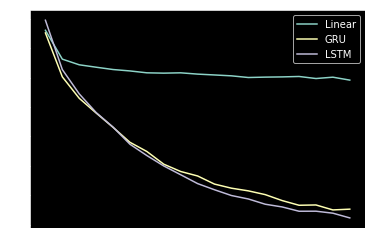

In [281]:
plt.plot(loss_linear), plt.plot(loss_gru), plt.plot(loss_lstm)
plt.legend(['Linear', 'GRU', 'LSTM'])

### How about a GRU Stack

In [ ]:
class WordGRUStack(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(WordGRU, self).__init__()
        self.gru = nn.GRU(n_input + n_categories, n_hidden, num_layers=2)
        self.h2o = nn.Linear(n_hidden, n_output)
    
    # note that x here is the full .shape(seq, batch, feature)
    def forward(self, x, cat, h):
        x = torch.cat((x, cat), 1)
        h = self.gru(x, h)
        o = self.h2o(h)
        o = F.dropout(o, 0.1)
        o = F.log_softmax(o, dim=1)
        return o, h
    
    def init_hidden(self):
        # num-layer x batch x number hidden
        zeros = torch.zeros(2, 1, n_hidden)
        if next(self.parameters()).is_cuda: zeros = zeros.cuda()
        return zeros

In [ ]:
gru_stack = WordGRUStack(n_letters, n_hidden, n_letters)